# Analysis of a Naive Stastic Arbitrage for Trading

<a href="https://www.kaggle.com/code/addarm/startarb-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![Basket of stocks done by MidJourney 12.2023](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/basket_of_stocks.png)

Statistical arbitrage (StatArb) is any technique in quantitative finance that is uses statistical and mathematical models to exploits a short-term market inefficiencies. 
A known StatArb is Pairs trading, which we discussed in a previous [article](https://medium.com/call-for-atlas/pairs-trading-strategy-every-stock-needs-a-friend-e50723a1dc94) and utilizes cointegration to trade a net market-neutral portfolio.

In this version of the algorithim, we will use a basket of weighted leading stocks to predict the divergence of their relationship with a target stock which ought to capture temporary lead-lag relationships in an efficient market.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


# Set up the Universe

We will load a basket of the hightes capitalized stocks from the Nasdaq100. Since StatArb is a tactical strategy, we will focus on correlation and covariance only, and filter the basket by this criteria.


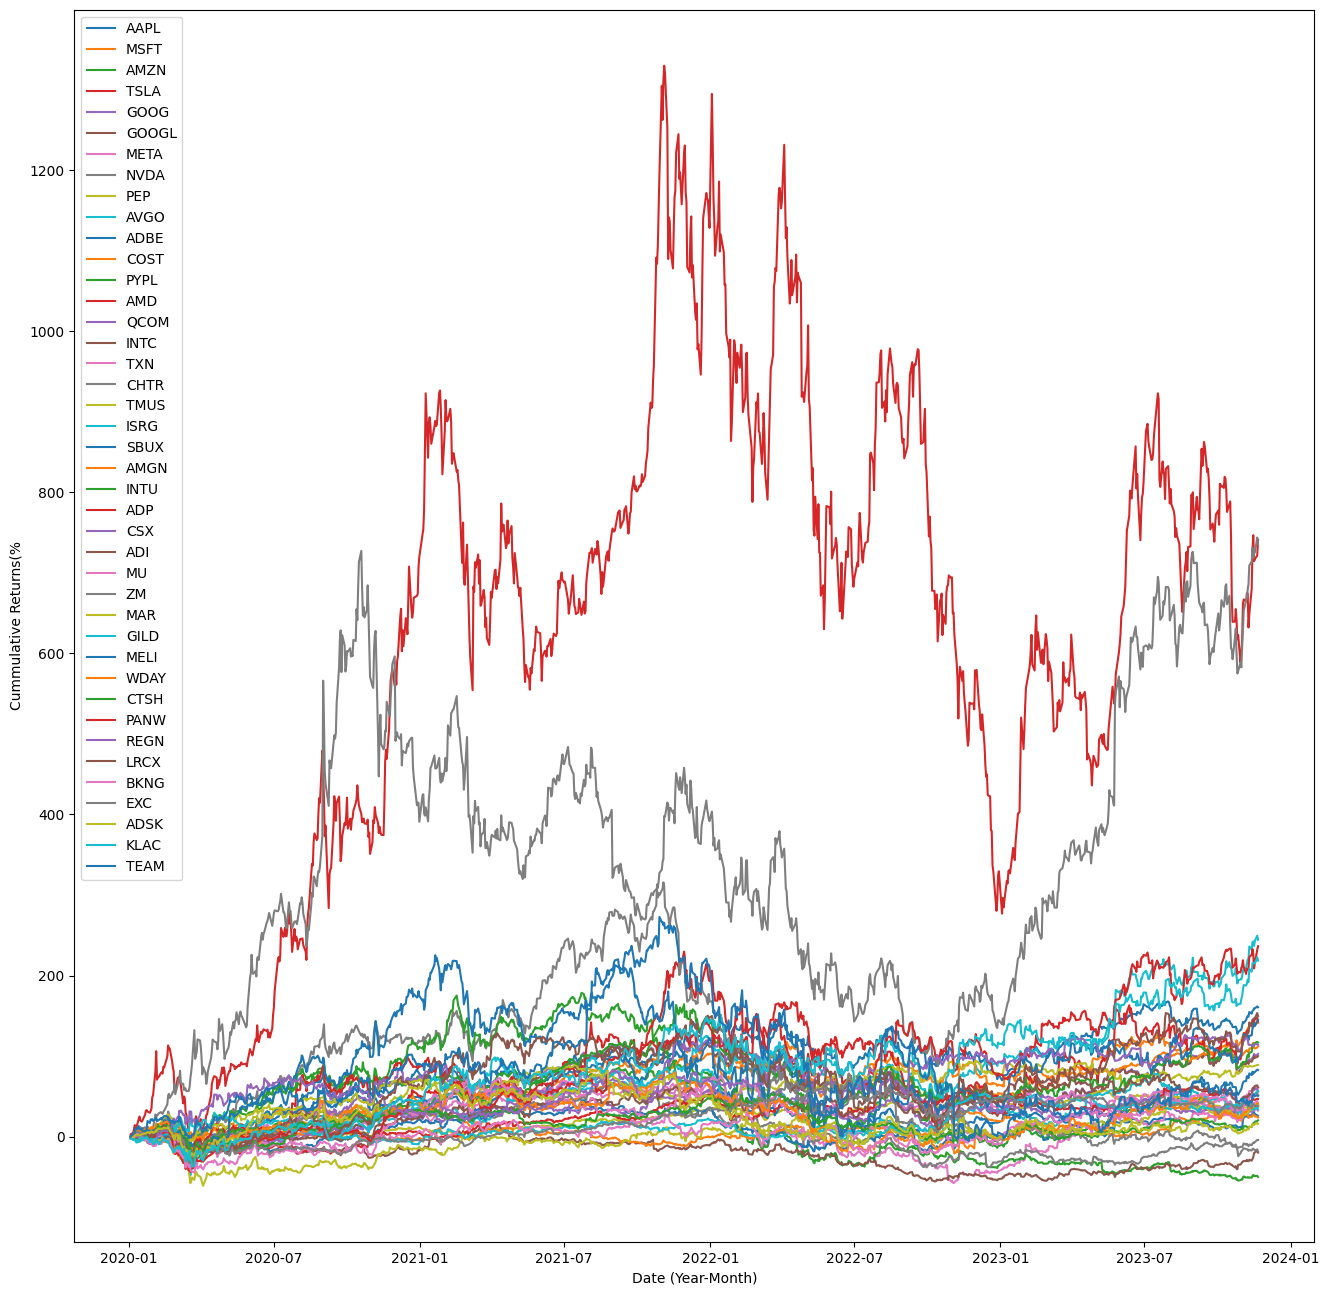

In [50]:
START_DATE = "2020-01-01"
END_DATE = "2023-11-22"

tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "TSLA",
    "GOOG",
    "GOOGL",
    "META",
    "NVDA",
    "PEP",
    "AVGO",
    "ADBE",
    "COST",
    "PYPL",
    "AMD",
    "QCOM",
    "INTC",
    "TXN",
    "CHTR",
    "TMUS",
    "ISRG",
    "SBUX",
    "AMGN",
    "INTU",
    "ADP",
    "CSX",
    "ADI",
    "MU",
    "ZM",
    "MAR",
    "GILD",
    "MELI",
    "WDAY",
    "CTSH",
    "PANW",
    "REGN",
    "LRCX",
    "BKNG",
    "EXC",
    "ADSK",
    "KLAC",
    "TEAM",
]
tickers_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_rets_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
tickers_rets_df = (1 + tickers_rets_df).cumprod() - 1

plt.figure(figsize=(16, 16))
for ticker in tickers_rets_df.columns:
    plt.plot(tickers_rets_df.index, tickers_rets_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

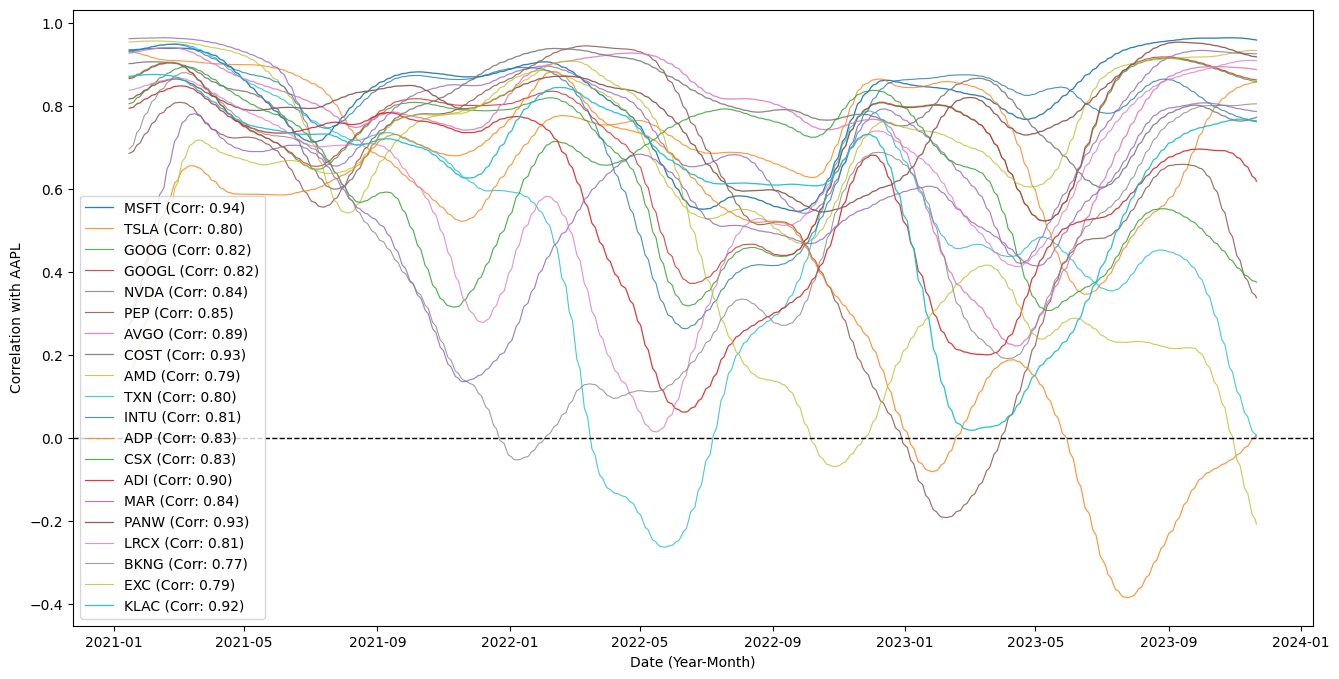

In [51]:
TARGET = "AAPL"
MA_WINDOW = 24
ARB_WINDOW = MA_WINDOW * 10
plt.figure(figsize=(16, 8))

corr_ticks = []
LEADS = []

for ticker in tickers:
    if ticker == TARGET:
        continue
    correlation = tickers_df[ticker].corr(tickers_df[TARGET])
    if abs(correlation) < 0.75:
        continue

    LEADS.append(ticker)

    corr_ts = tickers_df[ticker].rolling(ARB_WINDOW).corr(tickers_df[TARGET])
    plt.plot(
        tickers_df.index,
        corr_ts.rolling(MA_WINDOW).mean(),
        label=f"{ticker} (Corr: {correlation:.2f})",
        alpha=correlation,
        linewidth=correlation,
    )
    corr_ticks.append(ticker)

plt.axhline(y=0, color="k", linestyle="--", linewidth=1)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Correlation with AAPL")
plt.legend()
plt.show()

The above plot looks at the correlations overtime, we see that these oscillate between uncorrelated and correlated. 

In actual implementations, the basket of stocks gets redone periodicaly on specific factors - correlation could be one of these. Luckily for us, most of the chosen tickers like MSFT and GOOGL remain highly correlated during this simulation.

# Signalling Action

Let's go through the pseudocode for this naive StatArb algo we are builindg:
1. First we compute the exponential moving average (EMA) using a set window (we test 1 month). This is done for all stocks both leads and the target.
2. We calculate the delta of the current price from the EMA for all stocks.
3. Using a rolling window (we test 1/2 a year), we get the pair-wise correlation between the EMA differences of the leads and target stock. This captures the pairs short-term trends.  
4. We do the same for the covariance ratios between each pair. This quantifies how strongy the leader's price changes can project the target's. 
5. We use the covariance to make projections. Each leader's own EMA difference is multiplied by its covariance ratio with the target to project what the target's difference "should" be, if it moved in lockstep with the leader. This is similar to the cointegration algo in pairs-trading. 
6. The error between the projected and actual target EMA difference is calculated. This residual indicates how much the target is under or overperforming relative to the leader-based prediction. The sum of these will be our signal.
7. Finally we use the correlation ratios to wieght each lead's input to the signal.

Just as a reminder, covariance is:
$$ \text{Cov}(X, Y) = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{n} $$
Where:
- `Xbar` and `X` is the mean of X and an individual observation.  
- `Ybar` and `Y` is the mean of Y and an individual observation.  
- `N` is the number of observations

We use the covariance to give the correct magnitude of the movement of the leading stock, not the correlation coefficients (although this normalized value has some magnitude in it, this information has been lost). By itself covariance has no inherent interpretation.

here is the code:

In [52]:
arb_df = tickers_rets_df.copy()
arb_df["price"] = tickers_df[TARGET]
arb_df[f"ema_{TARGET}"] = arb_df[TARGET].ewm(MA_WINDOW).mean()
arb_df[f"ema_d_{TARGET}"] = arb_df[TARGET] - arb_df[f"ema_{TARGET}"]
arb_df[f"ema_d_{TARGET}"].fillna(0, inplace=True)

for ticker in LEADS:
    arb_df[f"ema_{ticker}"] = arb_df[ticker].ewm(MA_WINDOW).mean()
    arb_df[f"ema_d_{ticker}"] = arb_df[ticker] - arb_df[f"ema_{ticker}"]
    arb_df[f"ema_d_{ticker}"].fillna(0, inplace=True)
    arb_df[f"{ticker}_corr"] = (
        arb_df[f"ema_d_{ticker}"].rolling(ARB_WINDOW).corr(arb_df[f"ema_d_{TARGET}"])
    )
    arb_df[f"{ticker}_covr"] = (
        arb_df[[f"ema_d_{ticker}", f"ema_d_{TARGET}"]]
        .rolling(ARB_WINDOW)
        .cov(numeric_only=True)
        .groupby(level=0, axis=0, dropna=True)  # Cov returns pairwise!
        .apply(lambda x: x.iloc[0, 1] / x.iloc[0, 0])
    )
    arb_df[f"{ticker}_emas_d_prj"] = (
        arb_df[f"ema_d_{ticker}"] * arb_df[f"{ticker}_covr"]
    )
    arb_df[f"{ticker}_emas_act"] = (
        arb_df[f"{ticker}_emas_d_prj"] - arb_df[f"ema_d_{TARGET}"]
    )

arb_df.filter(regex=f"(_emas_d_prj|_corr|_covr)$").dropna().iloc[ARB_WINDOW:]

,MSFT_corr,MSFT_covr,MSFT_emas_d_prj,TSLA_corr,TSLA_covr,TSLA_emas_d_prj,GOOG_corr,GOOG_covr,GOOG_emas_d_prj,GOOGL_corr,...,LRCX_emas_d_prj,BKNG_corr,BKNG_covr,BKNG_emas_d_prj,EXC_corr,EXC_covr,EXC_emas_d_prj,KLAC_corr,KLAC_covr,KLAC_emas_d_prj
2021-11-26,0.612580,0.839504,0.055616,0.472720,0.032754,0.038246,0.308343,0.435160,-0.008875,0.330477,...,0.012525,-0.327753,-0.504663,0.059283,0.269705,0.686469,0.027165,0.230977,0.156145,0.019248
2021-11-29,0.621705,0.853348,0.090395,0.473388,0.032767,0.056861,0.306532,0.432055,0.011609,0.328948,...,0.024105,-0.340045,-0.517941,0.052070,0.271313,0.689754,0.037783,0.232782,0.157110,0.031252
2021-11-30,0.620469,0.856733,0.055605,0.475951,0.033068,0.057955,0.289995,0.407889,-0.010452,0.312419,...,0.023839,-0.360289,-0.541777,0.072384,0.266614,0.681345,0.013571,0.234827,0.159258,0.025488
2021-12-01,0.619945,0.859498,0.050884,0.474248,0.033109,0.037327,0.275748,0.386039,-0.014018,0.298249,...,0.028469,-0.379256,-0.561148,0.081020,0.259411,0.664739,0.006075,0.237797,0.161655,0.028382
2021-12-02,0.618596,0.861112,0.045845,0.472821,0.033226,0.032106,0.268183,0.375892,-0.001710,0.290235,...,0.016754,-0.389908,-0.574243,0.051714,0.256866,0.660362,0.015232,0.237542,0.162053,0.018846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,0.806229,1.040378,0.202470,0.707421,0.074712,0.025069,0.519043,0.663467,0.032854,0.529691,...,0.128505,0.125326,0.228964,0.015971,-0.148217,-0.378401,-0.006200,0.248233,0.201460,0.069955
2023-11-16,0.806942,1.034920,0.235074,0.705455,0.074714,0.000937,0.519152,0.664721,0.053254,0.529491,...,0.128923,0.127478,0.233437,0.016499,-0.145621,-0.374551,-0.003472,0.256638,0.207711,0.069229
2023-11-17,0.807774,1.033376,0.184828,0.703689,0.074804,0.002678,0.517832,0.664100,0.034664,0.527947,...,0.123776,0.129268,0.237005,0.016783,-0.143578,-0.372271,0.003397,0.264640,0.213599,0.067335
2023-11-20,0.808248,1.028098,0.224927,0.700523,0.074703,0.005818,0.515529,0.662414,0.042308,0.525439,...,0.157443,0.131812,0.241685,0.018967,-0.135353,-0.356389,0.001547,0.275481,0.220496,0.082902


We now weigh the signals:

In [53]:
weights = 0
delta_projected = 0
for ticker in LEADS:
    corr_abs = abs(arb_df[f"{ticker}_corr"].fillna(0))
    weights += corr_abs
    arb_df[f"{ticker}_emas_act_w"] = arb_df[f"{ticker}_emas_act"].fillna(0) * corr_abs
    delta_projected += arb_df[f"{ticker}_emas_act_w"]

weights = weights.replace(0, 1)
weights.dropna().iloc[ARB_WINDOW:]

2020-12-15    12.556095
2020-12-16    12.557300
2020-12-17    12.559124
2020-12-18    12.540436
2020-12-21    12.535084
                ...    
2023-11-15     9.278102
2023-11-16     9.314386
2023-11-17     9.346886
2023-11-20     9.379587
2023-11-21     9.398846
Name: MSFT_corr, Length: 739, dtype: float64

In [54]:
arb_df[f"{TARGET}_signal"] = delta_projected / weights
arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:]

2020-12-15   -0.060067
2020-12-16   -0.054206
2020-12-17   -0.055738
2020-12-18   -0.022274
2020-12-21   -0.050730
                ...   
2023-11-15   -0.056380
2023-11-16   -0.078522
2023-11-17   -0.074022
2023-11-20   -0.073613
2023-11-21   -0.065105
Name: AAPL_signal, Length: 739, dtype: float64

To visualize the quality of our signal, we'll calculate the errors and the signals confidence intervals at 95%.

$$ \text{Confidence Interval} = \bar{X} \pm Z \left(\frac{\sigma}{\sqrt{n}}\right) $$
Where:
- `Xhat` is the sample mean,
- `Z` is the Z-score corresponding to the desired confidence level (1.96 for a 95% confidence interval),
- `sigma` is the population's standard deviation or in our case, the residuals.
- `n` is the sample size.

The code below will calculate these criteria, and will be used later when acting on the signal:

In [55]:


errors = (
    arb_df[f"ema_{TARGET}"] + arb_df[f"ema_d_{TARGET}"] + arb_df[f"{TARGET}_signal"]
) - (arb_df[f"ema_{TARGET}"].shift(-1))
arb_df["rmse"] = np.sqrt((errors**2).rolling(ARB_WINDOW).mean()).fillna(0)

me = errors.rolling(ARB_WINDOW).mean().fillna(0)
e_std = errors.rolling(ARB_WINDOW).std().fillna(0)
ci = (me - 1.96 * e_std, me + 1.96 * e_std)

arb_df["ci_lower"] = arb_df[f"{TARGET}_signal"].fillna(0) + ci[0]
arb_df["ci_upper"] = arb_df[f"{TARGET}_signal"].fillna(0) + ci[1]
arb_df["ci_spread"] = arb_df["ci_upper"] - arb_df["ci_lower"]

arb_df.fillna(0, inplace=True)
arb_df[["ci_lower", "ci_upper"]].iloc[ARB_WINDOW:].tail(10)

,ci_lower,ci_upper
2023-11-08 00:00:00,-0.089492,0.052969
2023-11-09 00:00:00,-0.088051,0.054294
2023-11-10 00:00:00,-0.105307,0.037174
2023-11-13 00:00:00,-0.084821,0.057732
2023-11-14 00:00:00,-0.090031,0.052448
2023-11-15 00:00:00,-0.095494,0.046968
2023-11-16 00:00:00,-0.117655,0.024896
2023-11-17 00:00:00,-0.113162,0.029605
2023-11-20 00:00:00,-0.112755,0.030541
2023-11-21 00:00:00,-0.065105,-0.065105


# Visualizing the Signal and Errors

With the signal and error metrics ready, let's visualize it all:

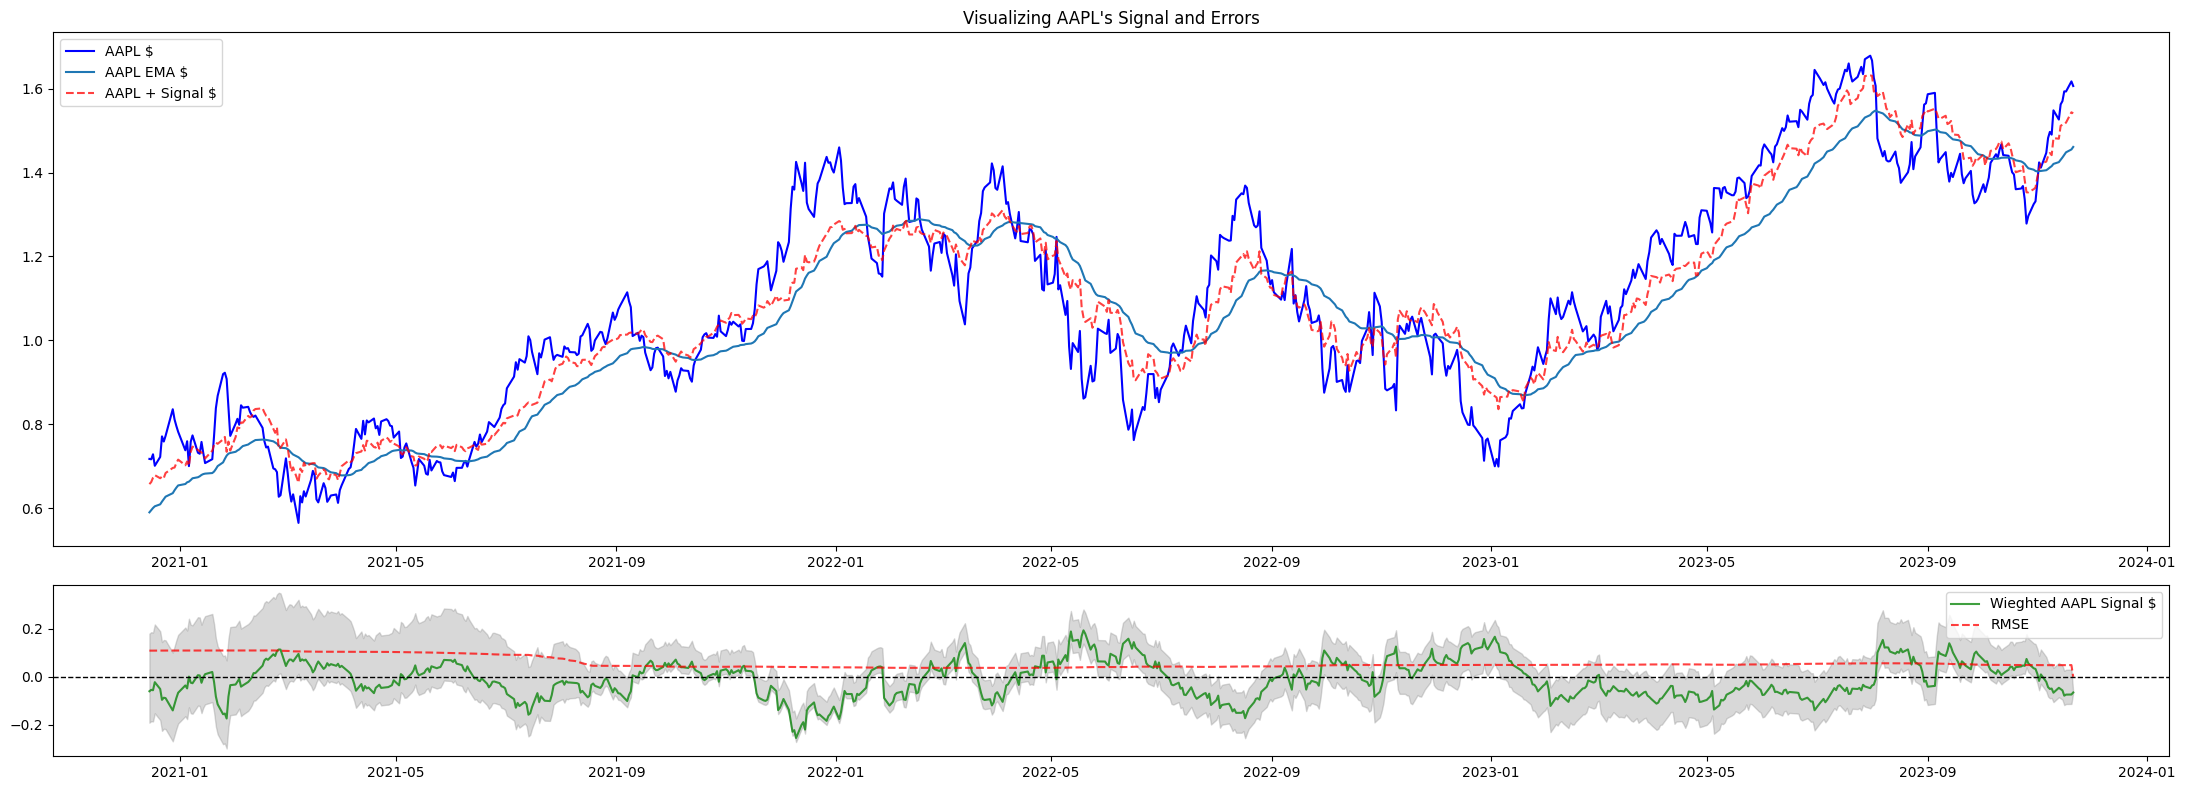

In [56]:
fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": (3, 1)}, figsize=(22, 8))

axes[0].set_title(f"Visualizing {TARGET}'s Signal and Errors")
axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[TARGET].iloc[ARB_WINDOW:],
    label=f"{TARGET} $",
    alpha=1,
    color="b",
)
axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"ema_{TARGET}"].iloc[ARB_WINDOW:],
    label=f"{TARGET} EMA $",
    alpha=1,
)
axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:].fillna(0)
    + arb_df[TARGET].iloc[ARB_WINDOW:],
    label=f"{TARGET} + Signal $",
    alpha=0.75,
    linestyle="--",
    color="r",
)
axes[0].legend()

axes[1].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:],
    label=f"Wieghted {TARGET} Signal $",
    alpha=0.75,
    color="g",
)
axes[1].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["rmse"].iloc[ARB_WINDOW:],
    label="RMSE",
    alpha=0.75,
    linestyle="--",
    color="r",
)
axes[1].fill_between(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["ci_lower"].iloc[ARB_WINDOW:],
    arb_df["ci_upper"].iloc[ARB_WINDOW:],
    color="gray",
    alpha=0.3,
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

Note how as the arbitrage's window rolls across more data, it's predictions become more 'accurate'. The tighter the confidence bands, the more likely we will simulate a trade.

I do have to say that in the post-covid market regime (2020-2023), there were some long running trends, helping our predictions' accuracy.

# Simulated Trading

Now let's act on our signals. This is a simulation, therefore we are ignoring various market nuances, ignoring stop losses and other expenses.

the code below will long/short a portfolio depending on the signals position to selected thresholds:

In [57]:
LONG_THRESHOLD = 0.0025
SHORT_THRESHOLD = -0.0025
CONF_SPREAD_THRESHOLD = 0.15  
MAX_SHARES = 1

arb_df["orders"] = 0
signals = arb_df[f"{TARGET}_signal"]
prev_signals = signals.shift(-1)

add_long_cond = (signals > LONG_THRESHOLD) & (prev_signals <= LONG_THRESHOLD) & (signals < arb_df["ci_upper"]) & (signals > arb_df["ci_lower"]) & (arb_df["ci_spread"] < CONF_SPREAD_THRESHOLD)
add_short_cond = (signals < SHORT_THRESHOLD) & (prev_signals >= SHORT_THRESHOLD) & (signals < arb_df["ci_upper"]) & (signals > arb_df["ci_lower"]) & (arb_df["ci_spread"] < CONF_SPREAD_THRESHOLD)


arb_df.loc[add_long_cond, "orders"] += MAX_SHARES
arb_df.loc[add_short_cond, "orders"] -= MAX_SHARES

arb_df["orders"].fillna(0, inplace=True)
arb_df.loc[arb_df["orders"] != 0, "orders"].tail(10)

2022-03-02 00:00:00    1
2022-03-18 00:00:00    1
2022-04-08 00:00:00   -1
2022-04-11 00:00:00    1
2022-04-13 00:00:00   -1
2022-05-03 00:00:00    1
2022-05-04 00:00:00   -1
2023-11-01 00:00:00    1
2023-11-02 00:00:00   -1
2023-11-03 00:00:00    1
Name: orders, dtype: int64

This code section uses Pandas to derive a PnL. A real life trade-execution system would be much different than this:

In [58]:
signal_changes_df = arb_df.loc[(add_long_cond | add_short_cond), ["price", "orders", f"{TARGET}_signal"]]

signal_changes_df["holdings"] = signal_changes_df["orders"].cumsum()
signal_changes_df["stat_chng"] = np.sign(signal_changes_df["orders"].shift(1)) != np.sign(signal_changes_df["orders"])
prev_holdings = signal_changes_df["holdings"].shift(1)

signal_changes_df["price_open"] = signal_changes_df["price"].shift(1)
signal_changes_df["cost_open_avg"] = (signal_changes_df.loc[signal_changes_df["stat_chng"] == False, "price_open"].shift(1) + signal_changes_df.loc[signal_changes_df["stat_chng"]== False, "price_open"]) / 2
signal_changes_df["cost_open_avg"].fillna(signal_changes_df["price_open"], inplace=True)
signal_changes_df["price_close"] = signal_changes_df["price"]
signal_changes_df["price_close"].iloc[0] = np.nan  # First signal shouldn't have a closing price

signal_changes_df["pnl"] = (signal_changes_df.loc[signal_changes_df["stat_chng"], "price_close"]  - signal_changes_df.loc[signal_changes_df["stat_chng"], "cost_open_avg"]) * np.sign(signal_changes_df["holdings"].shift(1))
signal_changes_df["pnl_rets"] = signal_changes_df["pnl"] / signal_changes_df["cost_open_avg"].abs()
signal_changes_df.fillna(0, inplace=True)

arb_df = pd.concat([arb_df, signal_changes_df[["pnl", "pnl_rets", "holdings"]]], axis=1).drop_duplicates(keep='last')

signal_changes_df.tail(10)

,price,orders,AAPL_signal,holdings,stat_chng,price_open,cost_open_avg,price_close,pnl,pnl_rets
2022-03-02 00:00:00,164.888245,1,0.003134,1,True,165.620804,165.620804,164.888245,-0.000000,-0.000000
2022-03-18 00:00:00,162.334106,1,0.018439,2,False,164.888245,155.980362,162.334106,0.000000,0.000000
2022-04-08 00:00:00,168.382812,-1,-0.017944,1,True,162.334106,162.334106,168.382812,6.048706,0.037261
2022-04-11 00:00:00,164.086380,1,0.019158,2,True,168.382812,168.382812,164.086380,-4.296432,-0.025516
2022-04-13 00:00:00,168.689697,-1,-0.033670,1,True,164.086380,164.086380,168.689697,4.603317,0.028054
2022-05-03 00:00:00,157.879272,1,0.045401,2,True,168.689697,168.689697,157.879272,-10.810425,-0.064085
2022-05-04 00:00:00,164.353622,-1,-0.010132,1,True,157.879272,157.879272,164.353622,6.474350,0.041008
2023-11-01 00:00:00,173.741104,1,0.013175,2,True,164.353622,164.353622,173.741104,9.387482,0.057118
2023-11-02 00:00:00,177.336380,-1,-0.017046,1,True,173.741104,173.741104,177.336380,3.595276,0.020693
2023-11-03 00:00:00,176.417572,1,0.009975,2,True,177.336380,177.336380,176.417572,-0.918808,-0.005181


Finally we visualize the trade's executed with the signal and within acceptable error measures:

<Figure size 2600x1800 with 0 Axes>

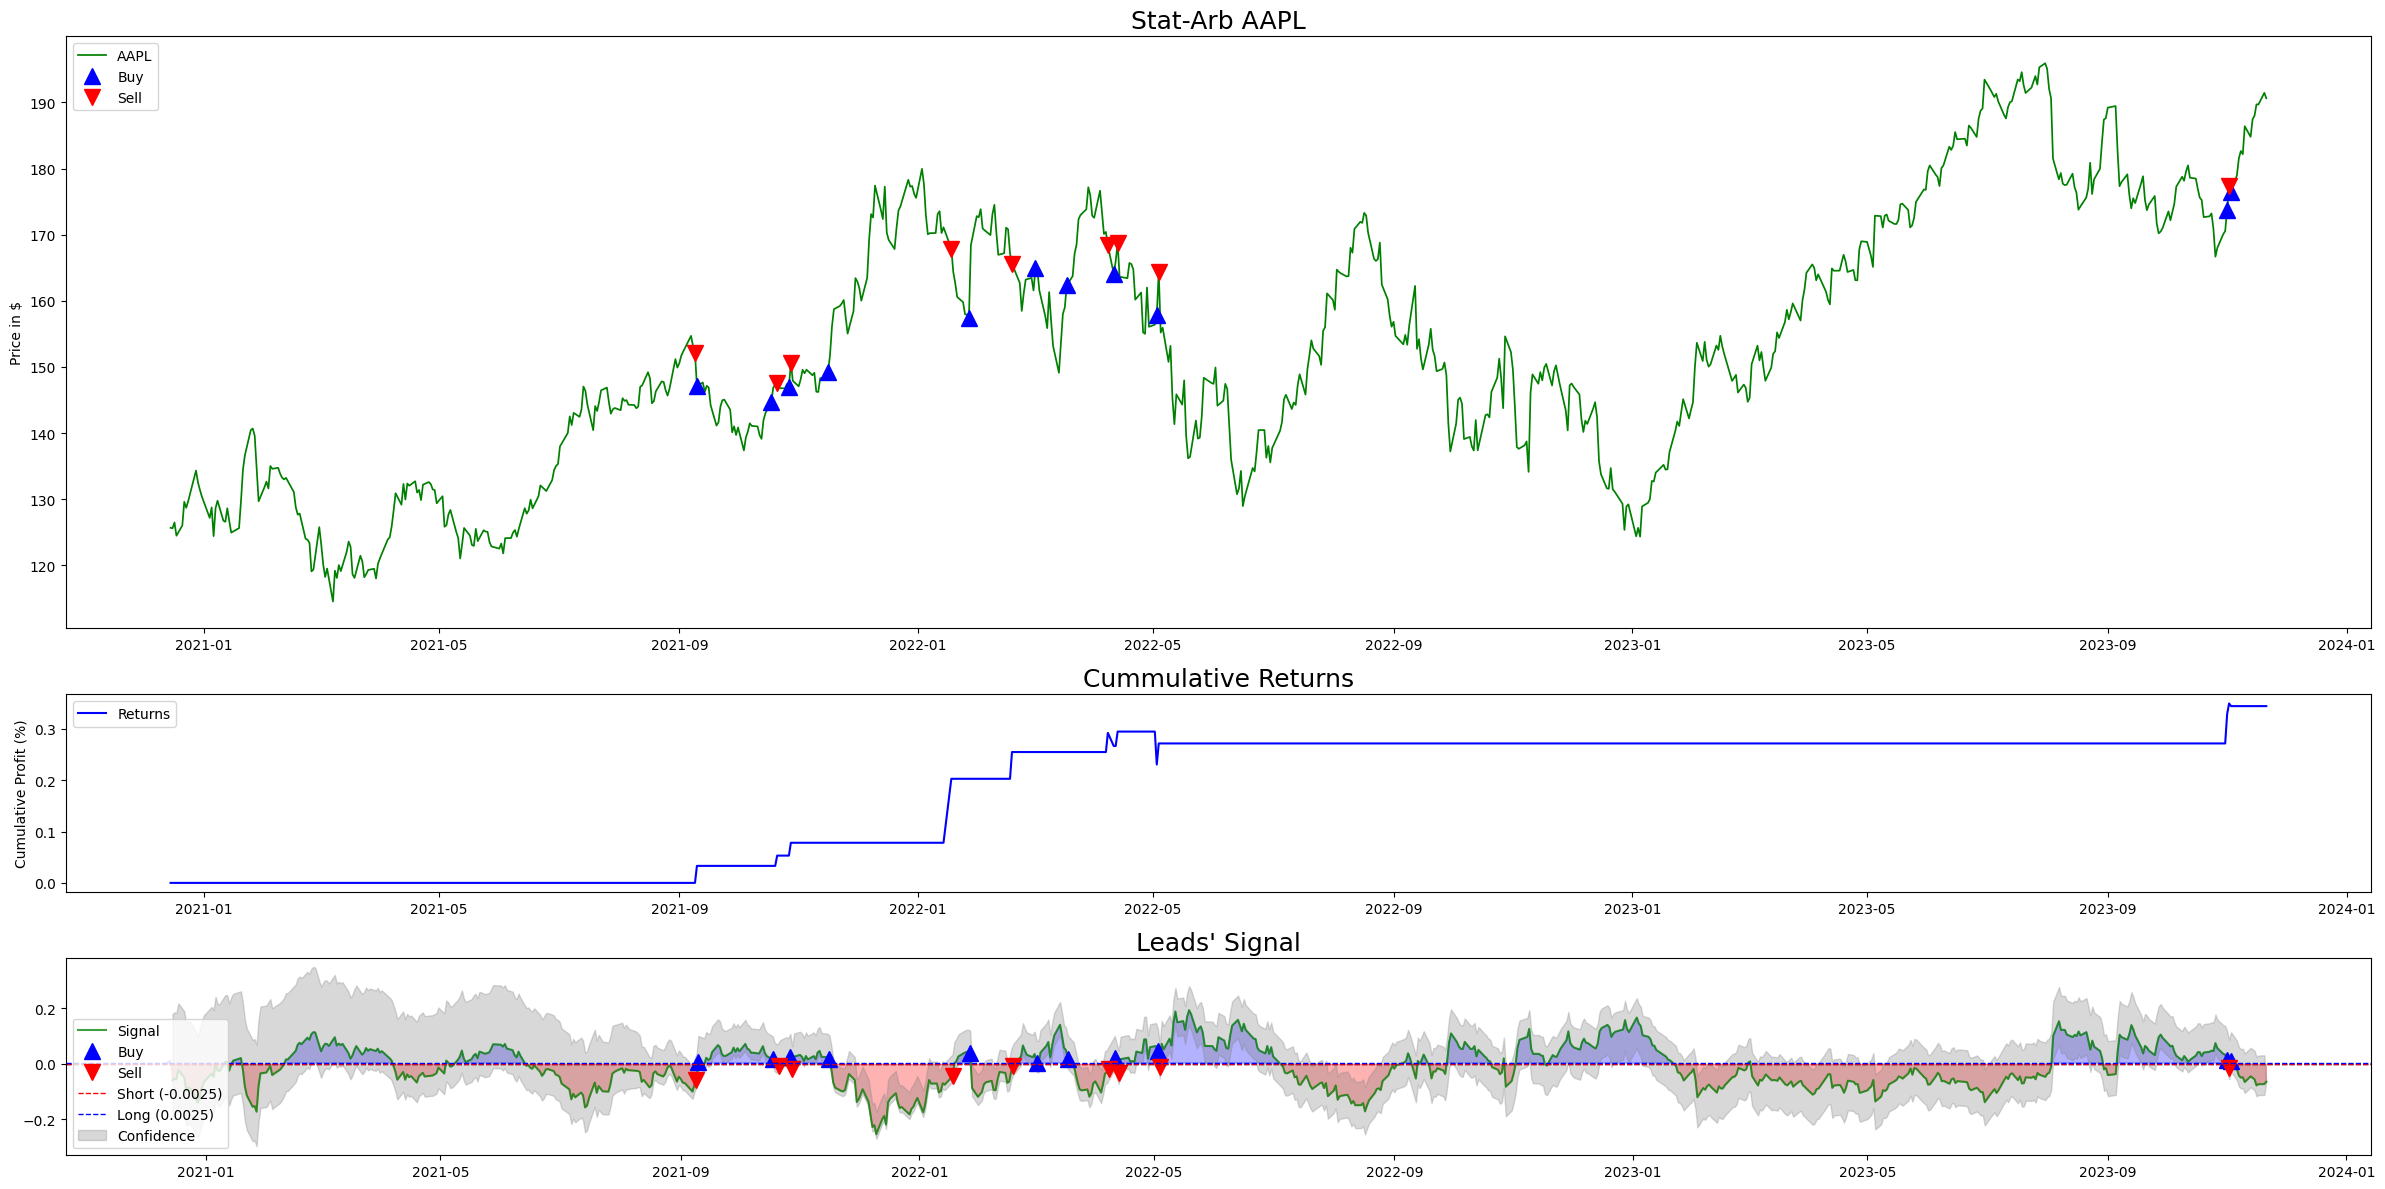

In [59]:
plt.figure(figsize=(26, 18))

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": (3, 1, 1)}, figsize=(24, 12)
)

ax1.plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["price"].iloc[ARB_WINDOW:],
    color="g",
    lw=1.25,
    label=f"{TARGET}",
)
ax1.plot(
    arb_df.loc[add_long_cond].index,
    arb_df.loc[add_long_cond, "price"],
    "^",
    markersize=12,
    color="blue",
    label="Buy",
)
ax1.plot(
    arb_df.loc[add_short_cond].index,
    arb_df.loc[add_short_cond, "price"],
    "v",
    markersize=12,
    color="red",
    label="Sell",
)
ax1.set_ylabel("Price in $")
ax1.legend(loc="upper left", fontsize=10)
ax1.set_title(f"Stat-Arb {TARGET}", fontsize=18)

ax2.plot(
    arb_df["pnl"].iloc[ARB_WINDOW:].index, arb_df["pnl_rets"].iloc[ARB_WINDOW:].fillna(0).cumsum(), color="b", label="Returns"
)
ax2.set_ylabel("Cumulative Profit (%)")
ax2.legend(loc="upper left", fontsize=10)
ax2.set_title(f"Cummulative Returns", fontsize=18)

ax3.plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:],
    label=f"Signal",
    alpha=0.75,
    color="g",
)
ax3.plot(
    arb_df.loc[add_long_cond].index,
    arb_df.loc[add_long_cond, f"{TARGET}_signal"],
    "^",
    markersize=12,
    color="blue",
    label="Buy",
)
ax3.plot(
    arb_df.loc[add_short_cond].index,
    arb_df.loc[add_short_cond, f"{TARGET}_signal"],
    "v",
    markersize=12,
    color="red",
    label="Sell",
)
ax3.axhline(0, color="black", linestyle="--", linewidth=1)
ax3.axhline(SHORT_THRESHOLD, color="r", linestyle="--", label=f"Short ({SHORT_THRESHOLD})",linewidth=1)
ax3.axhline(LONG_THRESHOLD, color="b", linestyle="--", label=f"Long ({LONG_THRESHOLD})",linewidth=1)
ax3.fill_between(arb_df.index, arb_df[f"{TARGET}_signal"], SHORT_THRESHOLD, where=(arb_df[f"{TARGET}_signal"] < SHORT_THRESHOLD), interpolate=True, color='red', alpha=0.3)
ax3.fill_between(arb_df.index, arb_df[f"{TARGET}_signal"], LONG_THRESHOLD, where=(arb_df[f"{TARGET}_signal"] > LONG_THRESHOLD), interpolate=True, color='blue', alpha=0.3)
ax3.fill_between(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["ci_lower"].iloc[ARB_WINDOW:],
    arb_df["ci_upper"].iloc[ARB_WINDOW:],
    color="gray",
    alpha=0.3,
    label=f"Confidence"
)
ax3.legend(loc="lower left", fontsize=10)
ax3.set_title(f"Leads' Signal", fontsize=18)

plt.tight_layout()
plt.show()

As this is a simulation, we have simplified the market as we did for the StatArb Algo. A real world variant would be high-frequency, trading intra-day or close to this, as alpha from market inefficiencies is taken in an instant.

We also skipped the back-testing, forward-testing, and parameter tuning of parameters like the rolling window lengths, and thresholds.

# Conclusion

In this article, we simulated a statistical arbitrage trading strategy built around confidence intervals and variance-weighted signals.

![Lock stepping with the market by MidJourney 12.2023](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/lockstepping_with_the_market.png)

## References

- https://www.nasdaq.com/solutions/nasdaq-100/companies
- https://www.investopedia.com/articles/trading/10/backtesting-walkforward-important-correlation.asp
- https://www.investopedia.com/articles/trading/07/statistical-arbitrage.asp

## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/startarb-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/startarb-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.